# Exploration 1: Rock-Paper-Scissors Image Classification

---

#### Model
* Keras Sequential API

#### Datasets
* Created my own datasets from [Teachable Machine](https://teachablemachine.withgoogle.com/)
* Gathered more datasets from the Aiffel mates

#### Model evaluation
* Loss and Accuracy
* Confusion Matrix
* Classification report

#### Goals

1. Get higher accuracy than the first time which was 0.37, hopefully above 0.80
2. Import more datasets
3. Use `sklearn.model_selection.train_test_split`
4. Plot Confusion matrix and Classification report
5. Validate my hypothesis: If test datasets are highly qualified than the train sets, then the accuracy will increase.

---

## Importing Dependencies

laying the foundation to build my model on

In [12]:
from PIL import Image #for resizing images
import os, glob, random, math
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("All imported!")

All imported!


---

## Data Pre-processing

### Images importing and resizing

Resizing images from 224x224 to 28x28

#### Anti-aliasing
* a technique for minimizing the distortion artifacts (aliasing) when representing a high-resolution image at a lower resolution
* basically it reduces the jaggedness and creates a "smoother" look


In [13]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")
    
    print(len(images), "images to be resized") # how many images are needed to be resized
    
    # resizing all images to 28x28
    target_size = (28,28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)# smooths the line
        new_img.save(img, "JPEG")
    
    print(len(images), "images resized.") # how many images have been resized
    
# reading all the jpg files from rock, paper and scissors directory

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/rock/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/paper/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/scissors/scissors"
resize_images(image_dir_path)

print("all images have been resized")

1904 images to be resized
1904 images resized.
1857 images to be resized
1857 images resized.
1959 images to be resized
1959 images resized.
all images have been resized


### Data loading and labeling

iglobe(): return an iterator which yields the same values as glob() without actually storing them all simultaneously. <br/>
[globe documentation](https://docs.python.org/3/library/glob.html)

In [14]:
def load_data(img_path, number_of_data = 5720):
    img_size = 28
    color = 3
    # matrix for images and labels
    imgs = np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels = np.zeros(number_of_data,dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path+'/scissors/scissors/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 0 # scissors : 0
        idx = idx+1
        
    for file in glob.iglob(img_path+'/rock/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 1 # rock : 1
        idx = idx+1
    
    for file in glob.iglob(img_path+'/paper/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 2 # paper : 2
        idx = idx+1
        
    print("a total of x_train images are", idx)
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp"
(x_train, y_train) = load_data(image_dir_path)
x_train_norm = x_train/255.0 # Min-Max Normalization, value lies in between 0 and 1

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

a total of x_train images are 5720
x_train shape: (5720, 28, 28, 3)
y_train shape: (5720,)


### Train_Test_Split

Validation Dataset: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.

In [15]:
# 80% into the train 20% into the validation
x_train, x_val, y_train, y_val = train_test_split(x_train_norm, y_train, test_size=0.2, shuffle=True, random_state=10)

# view the size of train and validation data
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(4576, 28, 28, 3) (1144, 28, 28, 3) (4576,) (1144,)


label 1


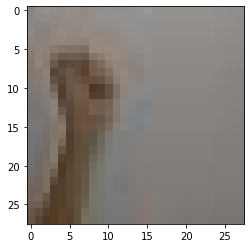

In [16]:
# view certain image and label
plt.imshow(x_train[1234])
print('label', y_train[1234])

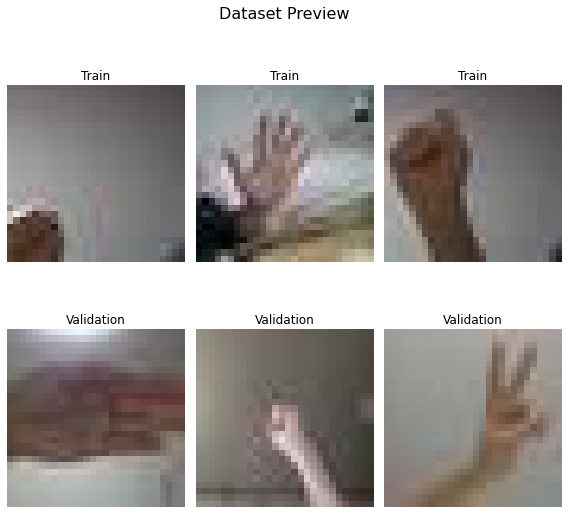

In [17]:
# one is not enough! much better way to view dataset
sample_train_images = [x_train[30], x_train[300], x_train[3000]]
sample_validation_images = [x_val[10], x_val[110], x_val[1110]]
sample_images = sample_train_images + sample_validation_images

plt.figure(figsize=(8,8))
plt.suptitle("Dataset Preview", fontsize = 16)

for i, image in enumerate(sample_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title('Train' if i < 3 else 'Validation', fontsize = 12)
    plt.axis('off')
    
plt.tight_layout()

---
## Deep Learning Network Training

### Model construction

Buidling a LeNet network, the Convolutional Neural Network(CNN)

* Conv2D: this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs. <br/>
The Keras Conv2D class constructor has the following arguments:
``` 
keras.layers.Conv2D(filters, kernel_size, strides=(1, 1),
  padding='valid', data_format=None, dilation_rate=(1, 1),
  activation=None, use_bias=True, kernel_initializer='glorot_uniform',
  bias_initializer='zeros', kernel_regularizer=None,
  bias_regularizer=None, activity_regularizer=None,
  kernel_constraint=None, bias_constraint=None)
  ```
* `activation = 'relu'`: Rectified Linear Unit, a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.<br/> It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

In [18]:
n_channel_1 = 16
n_channel_2 = 32
n_dense = 32
n_train_epoch = 20

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3, 3), activation = 'relu', input_shape = (28, 28, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(n_channel_2, (3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(3, activation = 'softmax'))

print('number of added layer:', len(model.layers))
model.summary()

number of added layer: 7
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              

### Compile and Fit

In [19]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

result = model.fit(x_train, y_train, epochs = n_train_epoch, validation_data=(x_val, y_val))

Epoch 1/20
143/143 [==============================] - 1s 5ms/step - loss: 1.0599 - accuracy: 0.4467 - val_loss: 0.9455 - val_accuracy: 0.5559
Epoch 2/20
143/143 [==============================] - 0s 3ms/step - loss: 0.7640 - accuracy: 0.6860 - val_loss: 0.6094 - val_accuracy: 0.7727
Epoch 3/20
143/143 [==============================] - 0s 3ms/step - loss: 0.5133 - accuracy: 0.8156 - val_loss: 0.3949 - val_accuracy: 0.8767
Epoch 4/20
143/143 [==============================] - 0s 3ms/step - loss: 0.3410 - accuracy: 0.8844 - val_loss: 0.2707 - val_accuracy: 0.9187
Epoch 5/20
143/143 [==============================] - 0s 3ms/step - loss: 0.2183 - accuracy: 0.9392 - val_loss: 0.2224 - val_accuracy: 0.9248
Epoch 6/20
143/143 [==============================] - 0s 3ms/step - loss: 0.1495 - accuracy: 0.9598 - val_loss: 0.1657 - val_accuracy: 0.9502
Epoch 7/20
143/143 [==============================] - 0s 3ms/step - loss: 0.0970 - accuracy: 0.9779 - val_loss: 0.1027 - val_accuracy: 0.9747
Epoch 

1. Hyperparameter #1 :<br/>
``` n_channel_1 = 16
n_channel_2 = 32
n_dense = 64
n_train_epoch = 20
```
<br/>
Epoch 16/20 <br/>
143/143 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 0.0098 - val_accuracy: 0.9991 <br/>
Epoch 17/20 <br/>
143/143 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9991

2. Hyperparameter #2:<br/>
``` n_channel_1 = 16
n_channel_2 = 32
n_dense = 64
n_train_epoch = 21
```
<br/>
Epoch 16/21 <br/>
143/143 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9969 - val_loss: 0.0153 - val_accuracy: 0.9974<br/>
Epoch 17/21 <br/>
143/143 [==============================] - 0s 3ms/step - loss: 0.0065 - accuracy: 0.9993 - val_loss: 0.0046 - val_accuracy: 1.0000

3. Hyperparameter #3:<br/>
``` n_channel_1 = 16
n_channel_2 = 32
n_dense = 64
n_train_epoch = 22
``` 
<br/>
Epoch 13/22 <br/>
143/143 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 0.9987 - val_loss: 0.0074 - val_accuracy: 1.0000 <br/>
Epoch 14/22 <br/>
143/143 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 0.9996 - val_loss: 0.0094 - val_accuracy: 0.9991

### Visualization

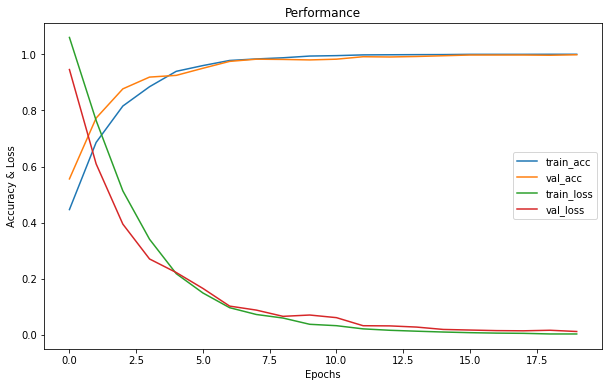

In [20]:
# visualizing the Loss and Accuracy values of train and validation datas
plt.figure(figsize=(10, 6))

plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])

plt.title('Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy & Loss')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='center right')

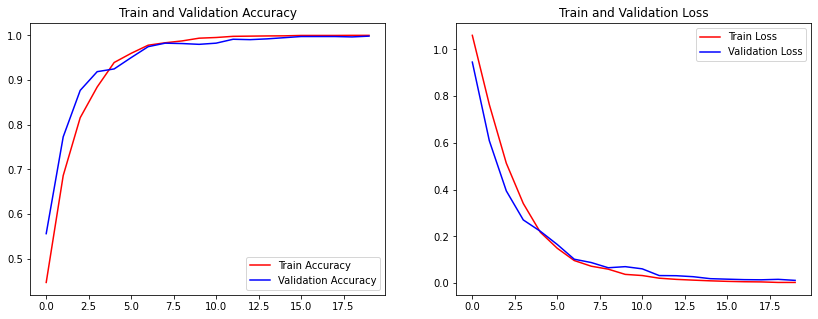

In [21]:
# visualizing train and validation accuracy vs train and vailidation loss
def eval_plot(result):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Train and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Train Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = result.history['loss']
  val_loss = result.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Train and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Train Loss', 'Validation Loss'])

eval_plot(result)

## Deep Learning Network Testing

### Importing test data

In [22]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.png")
    
    print(len(images), "images to be resized") # how many images are needed to be resized
    
    # resizing all images to 28x28
    target_size = (28,28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)# smooths the line
        new_img.save(img, "png")
    
    print(len(images), "images resized.") # how many images have been resized
    
# reading all the jpg files from rock, paper and scissors directory

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/test/scissors"
resize_images(image_dir_path)

print("all images have been resized")

123 images to be resized
123 images resized.
124 images to be resized
124 images resized.
124 images to be resized
124 images resized.
all images have been resized


In [23]:
def load_test_data(img_path, number_of_data = 371):
    img_size = 28
    color = 3
    # matrix for images and labels
    imgs = np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels = np.zeros(number_of_data,dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path+'/scissors/*.png'):
        img = np.array(Image.open(file), dtype=np.int32)
        img = Image.open(file).convert('RGB')
        imgs[idx,:,:,:] = img
        labels[idx] = 0 # scissors : 0
        idx = idx+1
        
    for file in glob.iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file), dtype=np.int32)
        img = Image.open(file).convert('RGB')
        imgs[idx,:,:,:] = img
        labels[idx] = 1 # rock : 1
        idx = idx+1
    
    for file in glob.iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file), dtype=np.int32)
        img = Image.open(file).convert('RGB')
        imgs[idx,:,:,:] = img
        labels[idx] = 2 # paper : 2
        idx = idx+1
        
    print("a total of x_test images are", idx)
    return imgs, labels


image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/test"
(x_test, y_test) = load_test_data(image_dir_path)
x_test_norm = x_test/255.0 # Min-Max Normalization, value lies in between 0 and 1

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

a total of x_test images are 371
x_test shape: (371, 28, 28, 3)
y_test shape: (371,)


Using the same codes from previous preprocessing, I came across with the value error which was <br/>
`ValueError: could not broadcast input array from shape (28, 28, 4) to (28,28, 3)` <br/>
Which means 'at least one item in your list is either not three dimensional, or its second or third dimension does not match the other elements.'

I've tried and failed
1. coverting numpy.ndarray to object using `.astype(object)`
2. using
```
from PIL import Image
img = Image.open(img_name).convert('RGB')
```

But once I've tried `.conver('RGB)` in for loops, I was able to solve the ValueError
[ThisHelped](https://github.com/carpedm20/DCGAN-tensorflow/issues/162)

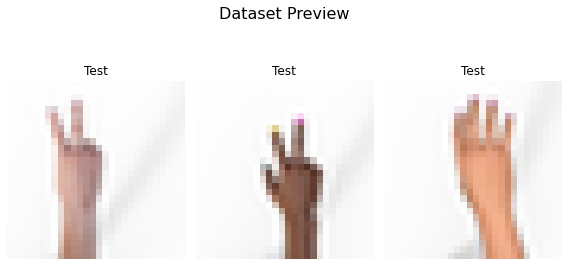

In [24]:
sample_test_images = [x_test_norm[30], x_test_norm[100], x_test_norm[300]]

plt.figure(figsize=(8,8))
plt.suptitle("Dataset Preview", fontsize = 16)

for i, image in enumerate(sample_test_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title('Test', fontsize = 12)
    plt.axis('off')
    
plt.tight_layout()

### Testing

In [25]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

12/12 - 0s - loss: 11.4811 - accuracy: 0.4879
test_loss: 11.481075286865234 
test_accuracy: 0.48787063360214233


In [26]:
predicted_result = model.predict(x_test_norm)
predicted_labels = np.argmax(predicted_result, axis=1)

probability distribution:  [1.0000000e+00 6.6252918e-14 2.0234999e-18]
label:  2
predicted result:  0


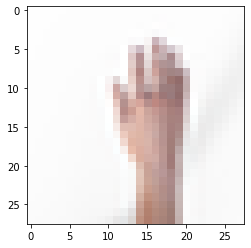

probability distribution:  [1.0000000e+00 6.3200675e-17 2.3856988e-14]
label:  2
predicted result:  0


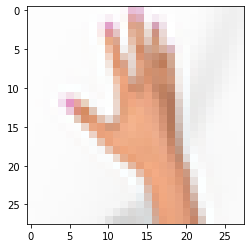

probability distribution:  [1.0000000e+00 1.6786248e-15 1.0917409e-20]
label:  2
predicted result:  0


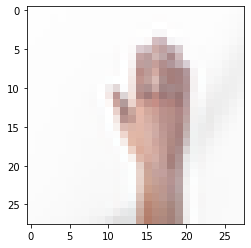

In [27]:
wrong_predict_list = []

for i, _ in enumerate(predicted_labels):
    if predicted_labels[i] != y_test[i]: 
        wrong_predict_list.append(i)
        
samples = random.choices(population=wrong_predict_list, k=3)

for n in samples:
    print("probability distribution: ", str(predicted_result[n]))
    print("label: ", str(y_test[n]))
    print("predicted result: ", str(predicted_labels[n]))
    
    plt.imshow(x_test_norm[n], cmap=plt.cm.binary)
    plt.show()

### Fine-tuning

#### First trial: resizing ==> epic fail

In [28]:
 target_size = (112,112)

Adjusted hyperparameters <br/>
First
* n_channel_1 = 16
* n_channel_2 = 32
* n_dense = 32
* n_train_epoch = 20 <br/>
test accuracy: 0.3450

Second
* n_channel_1 = 16
* n_channel_2 = 32
* n_dense = 64
* n_train_epoch = 10 <br/>
test accuracy: 0.3638 

#### Second trial: VGG16 ==> there's something wrong with my datasets

In [29]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")
    
    print(len(images), "images to be resized") # how many images are needed to be resized
    
    # resizing all images to 112x112
    target_size = (112,112)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)# smooths the line
        new_img.save(img, "JPEG")
    
    print(len(images), "images resized.") # how many images have been resized
    
# reading all the jpg files from rock, paper and scissors directory

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/rock/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/paper/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/scissors/scissors"
resize_images(image_dir_path)

print("all images have been resized")

1904 images to be resized
1904 images resized.
1857 images to be resized
1857 images resized.
1959 images to be resized
1959 images resized.
all images have been resized


In [30]:
def load_data(img_path, number_of_data = 5720):
    img_size = 112
    color = 3
    # matrix for images and labels
    imgs = np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels = np.zeros(number_of_data,dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path+'/scissors/scissors/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 0 # scissors : 0
        idx = idx+1
        
    for file in glob.iglob(img_path+'/rock/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 1 # rock : 1
        idx = idx+1
    
    for file in glob.iglob(img_path+'/paper/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 2 # paper : 2
        idx = idx+1
        
    print("a total of x_train_resized images are", idx)
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp"
(x_train_resized, y_train_resized) = load_data(image_dir_path)
x_train_resized_norm = x_train_resized/255.0 # Min-Max Normalization, value lies in between 0 and 1

print("x_train_resized shape: {}".format(x_train_resized.shape))
print("y_train_resized shape: {}".format(y_train_resized.shape))

a total of x_train_resized images are 5720
x_train_resized shape: (5720, 112, 112, 3)
y_train_resized shape: (5720,)


In [31]:
# 80% into the train 20% into the validation
x_train_resized, x_val_resized, y_train_resized, y_val_resized = train_test_split(x_train_resized_norm, y_train_resized, test_size=0.2, shuffle=True, random_state=10)

# view the size of train and validation data
print(x_train_resized.shape, x_val_resized.shape, y_train_resized.shape, y_val_resized.shape)

(4576, 112, 112, 3) (1144, 112, 112, 3) (4576,) (1144,)


In [32]:
from tensorflow.keras.applications import VGG16

model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))
model_vgg.trainable = False                                                       

model = keras.models.Sequential()
model.add(model_vgg)                                                               
model.add(keras.layers.Flatten())                    
model.add(keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2'))   
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2'))    
model.add(keras.layers.Dropout(0.5))                                               
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              18878464  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_______________________________________________________

In [33]:
EPOCH = 12
model.compile(optimizer='adam',                         
             loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'], )

history = model.fit(x_train_resized, y_train_resized, epochs=EPOCH, validation_data=(x_val_resized, y_val_resized))

Epoch 1/12
143/143 [==============================] - 12s 66ms/step - loss: 11.2499 - accuracy: 0.6510 - val_loss: 1.7803 - val_accuracy: 0.8129
Epoch 2/12
143/143 [==============================] - 8s 53ms/step - loss: 1.2678 - accuracy: 0.7725 - val_loss: 0.8175 - val_accuracy: 0.8680
Epoch 3/12
143/143 [==============================] - 8s 54ms/step - loss: 0.8272 - accuracy: 0.8125 - val_loss: 0.6452 - val_accuracy: 0.8767
Epoch 4/12
143/143 [==============================] - 8s 54ms/step - loss: 0.7985 - accuracy: 0.7896 - val_loss: 0.5471 - val_accuracy: 0.8934
Epoch 5/12
143/143 [==============================] - 8s 54ms/step - loss: 0.7420 - accuracy: 0.7926 - val_loss: 0.5526 - val_accuracy: 0.9213
Epoch 6/12
143/143 [==============================] - 8s 55ms/step - loss: 0.6994 - accuracy: 0.7979 - val_loss: 0.4772 - val_accuracy: 0.9108
Epoch 7/12
143/143 [==============================] - 8s 55ms/step - loss: 0.7102 - accuracy: 0.7788 - val_loss: 0.4376 - val_accuracy: 0.94

**Without validation dataset:**

Epoch 1/10 <br/>
179/179 [==============================] - 12s 53ms/step - loss: 50.8296 - accuracy: 0.8921 <br/>
Epoch 2/10 <br/>
179/179 [==============================] - 8s 46ms/step - loss: 26.0720 - accuracy: 0.9460<br/>
Epoch 3/10<br/>
179/179 [==============================] - 8s 46ms/step - loss: 20.8675 - accuracy: 0.9629<br/>
Epoch 4/10<br/>
179/179 [==============================] - 8s 47ms/step - loss: 20.7191 - accuracy: 0.9663<br/>
Epoch 5/10<br/>
179/179 [==============================] - 8s 47ms/step - loss: 18.3663 - accuracy: 0.9771<br/>
Epoch 6/10<br/>
179/179 [==============================] - 8s 47ms/step - loss: 16.0640 - accuracy: 0.9801<br/>
Epoch 7/10<br/>
179/179 [==============================] - 8s 47ms/step - loss: 21.2503 - accuracy: 0.9673<br/>
Epoch 8/10<br/>
179/179 [==============================] - 8s 46ms/step - loss: 19.6972 - accuracy: 0.9823<br/>
Epoch 9/10<br/>
179/179 [==============================] - 8s 46ms/step - loss: 17.4191 - accuracy: 0.9869<br/>
Epoch 10/10<br/>
179/179 [==============================] - 8s 46ms/step - loss: 16.7626 - accuracy: 0.9820<br/>

In [34]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.png")
    
    print(len(images), "images to be resized") # how many images are needed to be resized
    
    # resizing all images to 112x112
    target_size = (112,112)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)# smooths the line
        new_img.save(img, "png")
    
    print(len(images), "images resized.") # how many images have been resized
    
# reading all the jpg files from rock, paper and scissors directory

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/test/scissors"
resize_images(image_dir_path)

print("all images have been resized")

123 images to be resized
123 images resized.
124 images to be resized
124 images resized.
124 images to be resized
124 images resized.
all images have been resized


In [35]:
def load_test_resized_data(img_path, number_of_data = 371):
    img_size = 112
    color = 3
    # matrix for images and labels
    imgs = np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels = np.zeros(number_of_data,dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path+'/scissors/*.png'):
        img = np.array(Image.open(file), dtype=np.int32)
        img = Image.open(file).convert('RGB')
        imgs[idx,:,:,:] = img
        labels[idx] = 0 # scissors : 0
        idx = idx+1
        
    for file in glob.iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file), dtype=np.int32)
        img = Image.open(file).convert('RGB')
        imgs[idx,:,:,:] = img
        labels[idx] = 1 # rock : 1
        idx = idx+1
    
    for file in glob.iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file), dtype=np.int32)
        img = Image.open(file).convert('RGB')
        imgs[idx,:,:,:] = img
        labels[idx] = 2 # paper : 2
        idx = idx+1
        
    print("a total of x_test_resized images are", idx)
    return imgs, labels


image_dir_path = os.getenv("HOME") + "/aiffel/e1_rsp/test"
(x_test_resized, y_test_resized) = load_test_resized_data(image_dir_path)
x_test_resized_norm = x_test_resized/255.0 # Min-Max Normalization, value lies in between 0 and 1

print("x_test_resized shape: {}".format(x_test_resized.shape))
print("y_test_resized shape: {}".format(y_test_resized.shape))

a total of x_test_resized images are 371
x_test_resized shape: (371, 112, 112, 3)
y_test_resized shape: (371,)


In [36]:
test_loss_resized, test_accuracy_resized = model.evaluate(x_test_resized_norm, y_test_resized, verbose=0)
print("test_loss: {} ".format(test_loss_resized))
print("test_accuracy: {}".format(test_accuracy_resized))

test_loss: 0.969279408454895 
test_accuracy: 0.6388140320777893


#### third trial: VGG19 ==> Kernel died

In [37]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 256)      

---

## Conclusion

#### Model accuracy: 63%

#### Hypothesis: falsification

1. datasets are important GIGO!
2. adjusting hyperparameters are somewhat meaningful but getting better datasets would do much better
3. try confusion matrix and classification report nextime
4. achieved 3 out of 5 goals
5. DATA DATA DATA